## Effect of Image Size on Training

We Previously determined that the ADAM optimizer gave us the best results with a batch size of 256, and a learning rate of 0.0005. and with a gradient accumulation step size of 8 or batch size of 256. We will now try a variety of image sizes to determine if, as we might expect, that the full size images provide the best model.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)

Scans found: 112120 , Total Headers 112120
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [3]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [4]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [5]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [7]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

# Tuning Image Size

In [8]:
# Gradient Accumulation Borrowed from following location:
# https://stackoverflow.com/questions/55268762/how-to-accumulate-gradients-for-large-batch-sizes-in-keras

import keras.backend as K
from keras.legacy import interfaces
from keras.optimizers import Optimizer

class AdamAccumulate(Optimizer):

    def __init__(self, lr=0.005, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, accum_iters=1, **kwargs):
        if accum_iters < 1:
            raise ValueError('accum_iters must be >= 1')
        super(AdamAccumulate, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.accum_iters = K.variable(accum_iters, K.dtype(self.iterations))
        self.accum_iters_float = K.cast(self.accum_iters, K.floatx())

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        completed_updates = K.cast(K.tf.floordiv(self.iterations, self.accum_iters), K.floatx())

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * completed_updates))

        t = completed_updates + 1

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        # self.iterations incremented after processing a batch
        # batch:              1 2 3 4 5 6 7 8 9
        # self.iterations:    0 1 2 3 4 5 6 7 8
        # update_switch = 1:        x       x    (if accum_iters=4)  
        update_switch = K.equal((self.iterations + 1) % self.accum_iters, 0)
        update_switch = K.cast(update_switch, K.floatx())

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        gs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]

        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat, tg in zip(params, grads, ms, vs, vhats, gs):

            sum_grad = tg + g
            avg_grad = sum_grad / self.accum_iters_float

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * avg_grad
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(avg_grad)

            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, (1 - update_switch) * vhat + update_switch * vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, (1 - update_switch) * m + update_switch * m_t))
            self.updates.append(K.update(v, (1 - update_switch) * v + update_switch * v_t))
            self.updates.append(K.update(tg, (1 - update_switch) * sum_grad))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, (1 - update_switch) * p + update_switch * new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulate, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
#This was determined earlier in the training data loader
STEPS_PER_EPOCH = 1000
EPOCHS = 100

In [10]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers

def MakeModel(IMG_SIZE, bs):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, 1), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

### Here we set the steps per epoch and the batch size so regardless of learning rate, we are looking at the same number of examples

In [11]:
IMG_SIZE_LIST = [(1024, 1024), (512, 512), (256, 256), (224, 224), (192,192) ,(128, 128), (64, 64)]

Found 28272 validated image filenames belonging to 13 classes.
Found 9429 validated image filenames belonging to 13 classes.
Found 28272 validated image filenames belonging to 13 classes.
Found 9429 validated image filenames belonging to 13 classes.
Running Image Size:  (1024, 1024) Running Batch size :  4 Learning Rate :  0.0005
Epoch 1/100
1000/1000 [==============================] - 368s 368ms/step - loss: 0.4504 - binary_accuracy: 0.8283 - mean_absolute_error: 0.2167 - val_loss: 0.4096 - val_binary_accuracy: 0.8462 - val_mean_absolute_error: 0.2008

Epoch 00001: val_loss did not improve from 0.25166
Epoch 2/100
1000/1000 [==============================] - 373s 373ms/step - loss: 0.3723 - binary_accuracy: 0.8602 - mean_absolute_error: 0.2140 - val_loss: 0.3684 - val_binary_accuracy: 0.8462 - val_mean_absolute_error: 0.2124

Epoch 00002: val_loss did not improve from 0.25166
Epoch 3/100
1000/1000 [==============================] - 377s 377ms/step - loss: 0.3662 - binary_accuracy: 0.8

1000/1000 [==============================] - 82s 82ms/step - loss: 0.3638 - binary_accuracy: 0.8607 - mean_absolute_error: 0.2077 - val_loss: 0.3657 - val_binary_accuracy: 0.8462 - val_mean_absolute_error: 0.2048

Epoch 00006: val_loss did not improve from 0.25166
Epoch 7/100
1000/1000 [==============================] - 81s 81ms/step - loss: 0.3594 - binary_accuracy: 0.8635 - mean_absolute_error: 0.2078 - val_loss: 0.3462 - val_binary_accuracy: 0.8654 - val_mean_absolute_error: 0.2020

Epoch 00007: val_loss did not improve from 0.25166
Epoch 8/100
1000/1000 [==============================] - 82s 82ms/step - loss: 0.3590 - binary_accuracy: 0.8618 - mean_absolute_error: 0.2087 - val_loss: 0.3553 - val_binary_accuracy: 0.8654 - val_mean_absolute_error: 0.2039

Epoch 00008: val_loss did not improve from 0.25166
Epoch 9/100
1000/1000 [==============================] - 82s 82ms/step - loss: 0.3542 - binary_accuracy: 0.8641 - mean_absolute_error: 0.2048 - val_loss: 0.3527 - val_binary_accurac

1000/1000 [==============================] - 72s 72ms/step - loss: 0.3882 - binary_accuracy: 0.8535 - mean_absolute_error: 0.2087 - val_loss: 0.3186 - val_binary_accuracy: 0.8846 - val_mean_absolute_error: 0.1867

Epoch 00006: val_loss did not improve from 0.25166
**************************************************

Found 28272 validated image filenames belonging to 13 classes.
Found 9429 validated image filenames belonging to 13 classes.
Found 28272 validated image filenames belonging to 13 classes.
Found 9429 validated image filenames belonging to 13 classes.
Running Image Size:  (64, 64) Running Batch size :  4 Learning Rate :  0.0005
Epoch 1/100
1000/1000 [==============================] - 102s 102ms/step - loss: 0.5232 - binary_accuracy: 0.8165 - mean_absolute_error: 0.2123 - val_loss: 0.3375 - val_binary_accuracy: 0.8654 - val_mean_absolute_error: 0.1856

Epoch 00001: val_loss did not improve from 0.25166
Epoch 2/100
1000/1000 [==============================] - 67s 67ms/step - los

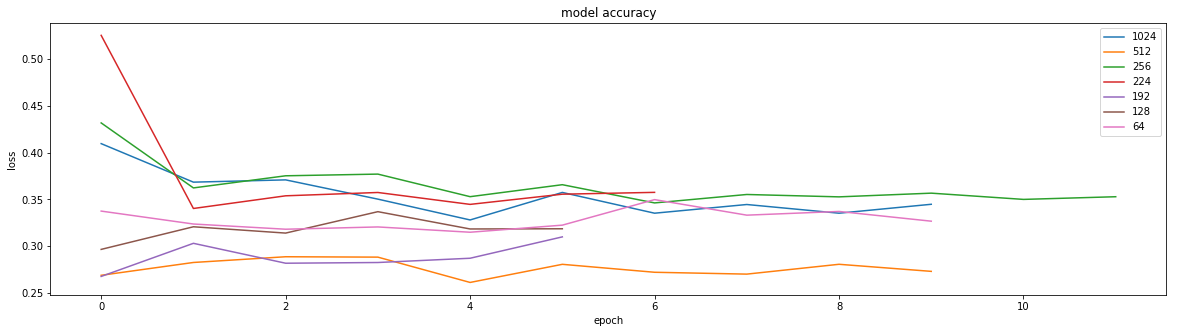

<Figure size 432x288 with 0 Axes>

In [15]:
import gc
from collections import defaultdict
from sklearn.metrics import log_loss

run_this_code = True # This Code Block Takes a long time to run

if run_this_code:
    train_results = defaultdict(dict)
    test_results  = defaultdict(dict)
    
    lr = 0.0005
    syntheticBatch = 256
    
    plt.figure(figsize=(20,5))

    for imageSize in IMG_SIZE_LIST: #Number of batches before gradient accumulation
        batchSize = 4
        batch = 256 / batchSize
        
        train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = batchSize)

        valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = batchSize) # we can use much larger batches for evaluation

        train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = 1024))

        test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                                 directory=None,
                                 x_col = 'path',
                                y_col = 'newLabel', 
                                 class_mode = 'categorical',
                                classes = all_labels,
                                target_size = imageSize,
                                 color_mode = 'grayscale',
                                batch_size = 1024))

        print ('Running Image Size: ', imageSize, 'Running Batch size : ', 
               batchSize, 'Learning Rate : ', lr)
        
        predictions_train = pd.DataFrame()
        predictions_test  = pd.DataFrame()

        opt = AdamAccumulate(lr=lr, accum_iters=int(batch)) #Set the gradient accumulation value
        multi_disease_model = MakeModel(imageSize, batchSize)
        multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
               metrics = ['binary_accuracy', 'mae'])

        history = multi_disease_model.fit_generator(train_gen, 
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data = (test_X, test_Y), 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list)

        multi_disease_model.load_weights(weight_path)
        
    
        plt.plot(history.history['val_loss'])
    


        p = history.history['val_loss'][0]

        del multi_disease_model, history
        gc.collect()
        print('*'*50)
        print('')

        test_results[imageSize[0]][lr]  = p
        imageSizeFile = pd.DataFrame(test_results)
        imageSizeFile.to_csv("imageSize.csv", index=True)

    plt.legend([str(x[0]) for x in IMG_SIZE_LIST], loc='upper right')
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.savefig('image_size_selection.png', bbox_inches='tight')

In [16]:
test_results

defaultdict(dict,
            {1024: {0.0005: 0.40957993268966675},
             512: {0.0005: 0.2689187228679657},
             256: {0.0005: 0.43170666694641113},
             224: {0.0005: 0.5252531170845032},
             192: {0.0005: 0.26770344376564026},
             128: {0.0005: 0.2965983748435974},
             64: {0.0005: 0.3375091552734375}})

In [17]:
imageSizeSummary = pd.read_csv("imageSize.csv")

In [18]:
imageSizeSummary

,Unnamed: 0,1024,512,256,224,192,128,64
0,0.0005,0.40958,0.268919,0.431707,0.525253,0.267703,0.296598,0.337509


#### Analysis of Image Size:

The above table shows image size resolution.  Mobile net was designed for 224 x 224. VGG19 was also designed with a native resolution of 224 x 224.  However, inceptionV3 resnet was designed with a resolution of 299 x 299.  We would expect no improvement in performance beyond the initial design of the network.  However, we do in fact see some improvement with images of size 512 x 512.  Therefore, we will go forward with a resolution of 512 x 512, knowing with confidence that we should get results at least as good as using the native resolution of the various models (299 x 299).



#### Hyper-Parameter Tuning:

Going forward we can use the ADAM optimizer along with a batch size of 256 using gradient accumulation every 8th step with an actual batch size of 32.

We can use image size of (512 x 512)

# Create Mobile Net Model

In [11]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)

batchSize = 16
batch = 256 / batchSize

train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'grayscale',
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'grayscale',
                        batch_size = 1024) # we can use much larger batches for evaluation

train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'grayscale',
                        batch_size = 1024))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'grayscale',
                        batch_size = 1024))


opt = AdamAccumulate(lr=lr, accum_iters=int(batch)) #Set the gradient accumulation value
multi_disease_model = MakeModel(imageSize, batchSize)
multi_disease_model.compile(optimizer = opt, loss = 'binary_crossentropy',
       metrics = ['binary_accuracy', 'mae'])

history = multi_disease_model.fit_generator(train_gen, 
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data = (test_X, test_Y), 
              epochs = EPOCHS, 
              callbacks = callbacks_list)

Found 28227 validated image filenames belonging to 13 classes.
Found 9403 validated image filenames belonging to 13 classes.
Found 28227 validated image filenames belonging to 13 classes.
Found 9403 validated image filenames belonging to 13 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1000/1000 [==============================] - 472s 472ms/step - loss: 0.4030 - binary_accuracy: 0.8488 - mean_absolute_error: 0.2128 - val_loss: 0.3268 - val_binary_accuracy: 0.8702 - val_mean_absolute_error: 0.1900

Epoch 00001: val_loss improved from inf to 0.32683, saving model to xray_class_weights.best.hdf5
Epoch 2/100
1000/1000 [==============================] - 467s 467ms/step - loss: 0.3557 - binary_accuracy: 0.8636 - mean_absolute_error: 0.2076 - val_loss: 0.3219 - val_binary_accuracy: 0.87

1000/1000 [==============================] - 480s 480ms/step - loss: 0.3137 - binary_accuracy: 0.8746 - mean_absolute_error: 0.1880 - val_loss: 0.2890 - val_binary_accuracy: 0.8894 - val_mean_absolute_error: 0.1774

Epoch 00024: val_loss did not improve from 0.28079
Epoch 25/100
1000/1000 [==============================] - 464s 464ms/step - loss: 0.3107 - binary_accuracy: 0.8770 - mean_absolute_error: 0.1863 - val_loss: 0.2799 - val_binary_accuracy: 0.9038 - val_mean_absolute_error: 0.1735

Epoch 00025: val_loss improved from 0.28079 to 0.27993, saving model to xray_class_weights.best.hdf5
Epoch 26/100
1000/1000 [==============================] - 471s 471ms/step - loss: 0.3120 - binary_accuracy: 0.8755 - mean_absolute_error: 0.1869 - val_loss: 0.2932 - val_binary_accuracy: 0.9135 - val_mean_absolute_error: 0.1752

Epoch 00026: val_loss did not improve from 0.27993
Epoch 27/100
1000/1000 [==============================] - 460s 460ms/step - loss: 0.3115 - binary_accuracy: 0.8758 - mean_a

# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

In [19]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = 'grayscale',
                        batch_size = 9403))

Found 9403 validated image filenames belonging to 13 classes.


In [21]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

9403/9403 [==============================] - 37s 4ms/step


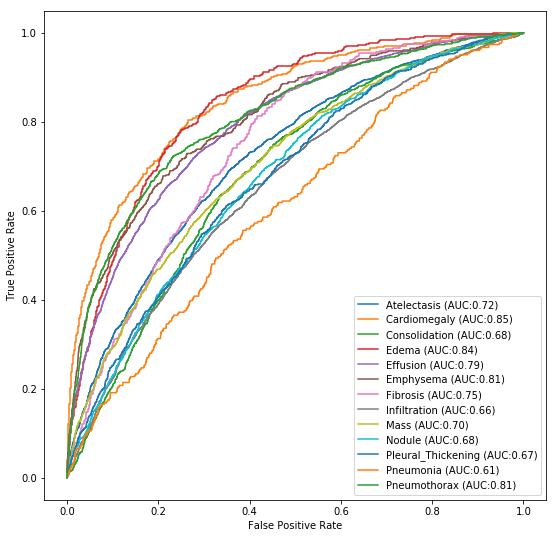

In [22]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')